VENUS NOTEBOOK TAKE 2

In [1]:
using Revise
using PyPlot
using PyCall
using HDF5
using DataFrames
using Interpolations 
using DelimitedFiles
using XLSX
using Printf
photochemistry_source_dir = "$(@__DIR__)/Photochemistry/src/"
println("loading Photochemistry.jl from $photochemistry_source_dir")
push!(LOAD_PATH, photochemistry_source_dir)
using Photochemistry  # custom module
using QuadGK
import Base.@kwdef
using GeneralizedGenerated

loading Photochemistry.jl from /home/mike/Documents/Proposals/2022_Venus_H/proposal/ion_model/VenusPhotochemistry/Photochemistry/src/


In [2]:
include("CUSTOMIZATIONS.jl");
include("CONSTANTS.jl");

# Functions

In [3]:
function plot_ion_ranges_wide_2panel(ions_to_plot, simfolder, savepath;
                          comparison_ions=[:CO2pl, :O2pl, :Opl], showonly=false, extra_fn="", xL = [1e-7, 1e7],
                          posdict = Dict(:ArDpl => [8e-7, 190], :Dpl => [3e-3, 260], :DCOpl => [0.7, 175], :DOCpl => [2e-5, 260], :DCO2pl => [1.5e-2, 150], 
                                         :HDOpl => [2e-4, 260], :H2DOpl => [1e-3, 100], :HDpl => [1e-6, 150], 
                                         :H2Dpl => [2e-6, 260], :N2Dpl => [3e-4, 145], :ODpl => [6e-3, 240],
                                         :ArHpl => [3e-6, 210], :Hpl => [1.7e-4, 220], :HCOpl => [9e-2, 175], :HOCpl => [1.5e-5, 230], :HCO2pl => [1.5e-3, 150],
                                         :H2Opl => [1e-3, 175], :H3Opl => [1.7e-5, 235], :H2pl => [8e-4, 235], 
                                         :H3pl => [3e-6, 240], :N2Hpl => [1e-3, 165], :OHpl => [6e-4, 210],
                                         :CO2pl => [1e3, 130], :O2pl => [2e3, 240], :Opl => [15, 135],))


    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 16
    rcParams["axes.titlesize"] = 18
    rcParams["axes.labelsize"]= 16
    rcParams["xtick.labelsize"] = 16
    rcParams["ytick.labelsize"] = 16
    rcParams["lines.linewidth"] = 1
    
    # Load the 3 atmospheres
    ncur = get_ncurrent(simfolder*"final_atmosphere.h5")

    # set up the overall plot -------------------------------------------------------------
    ncol = 1
    nrow = 2
    fig, ax = subplots(nrow, ncol, figsize=(16,10), gridspec_kw=Dict("height_ratios"=>[1,1], "hspace"=>0.06))
    ax[1].set_title("Ion densities in detail")
    ax[nrow].set_xlabel(L"Number density (cm$^{-3}$)")
    
    for a in ax
        plot_bg(a)
        a.tick_params(which="both", labeltop=false, top=true, labelbottom=false, bottom=true, labelleft=true)
        a.set_ylim(80, zmax/1e5)
        a.set_yticks(100:50:zmax/1e5)
        a.set_xscale("log")
        a.set_xlim(xL[1], xL[2])
        a.set_ylabel("Altitude (km)")
    end
    
    # Set the right limit to 2e5 for just the solar mean plot with D ions since we need to show the comparisons
    ax[1].set_xlim(right=xL[2])
    ax[2].set_xlim(right=xL[2])
    
    # These have to go here to override the previous setting
    ax[1].tick_params(which="both", labeltop=true)
    ax[nrow].tick_params(which="both", labelbottom=true)
    
    # plot the ions according to logical groups ------------------------------------------------------------
    lineorder = Dict([i=>4 for i in comparison_ions])

    for ion in ions_to_plot
        row = occursin("D", string(ion)) ? 2 : 1  # set column based on ion

        # style things
        thiscolor = get(speciescolor, ion, dimcolor)
        this_zorder = 10

        # Axes showing range of values
        ax[row].plot(ncur[ion], plot_grid, color=thiscolor, linewidth=2, label=ion, zorder=this_zorder)
        ax[row].text(posdict[ion]..., string_to_latexstr(string(ion)), color=thiscolor, va="top", transform=ax[row].transAxes)
    end

    # Plot comparison ions
    for comp_ion in comparison_ions
        for i in 1:nrow
            if i < 3
                position = posdict[comp_ion]
            else 
                position = posdict[comp_ion]
            end
            
            ax[i].plot(ncur[comp_ion], plot_grid, color=dimcolor,
                          linewidth=2, label=comp_ion, zorder=get(lineorder, comp_ion, 10))
            ax[i].text(position..., string_to_latexstr(string(comp_ion)), color=get(speciescolor_forDions, comp_ion, dimcolor), va="top", zorder=15,  transform=ax[i].transAxes)
        end
    end

    
    # Indicate H and D species
    fs = 34
    ax[1].text(0.9, 0.9, "H ions", color="#696969", fontsize=fs, va="top", transform=ax[1].transAxes)
    ax[2].text(0.9, 0.9, "D ions", color="#696969", fontsize=fs, va="top", transform=ax[2].transAxes)
    
    # Show and save
    if showonly==false
        savefig(savepath*"H_and_D_ions$(extra_fn)_wide.png", bbox_inches="tight", dpi=300)
    end
    show()
end


plot_ion_ranges_wide_2panel (generic function with 1 method)

# Load and set folders

In [4]:
# In case results dir is different in the file (running simulations for other paper)
results_dir = code_dir*"../Results/"

all_result_plot_folder = "$(@__DIR__)/../Results/FirstLook_Plots/"

"/home/mike/Documents/Proposals/2022_Venus_H/proposal/ion_model/VenusPhotochemistry/../Results/FirstLook_Plots/"

In [5]:
mean_folder = results_dir*"I-Ts735Tm170Te290-W1e-6-Smean_c1JKkl1M_venus_initial_convergence_v0.7/"  # fixed BC sign convention, Ar transport
#mean_folder = results_dir*"I-Ts735Tm170Te290-W1e-5-Smean_TBKJGoKI_venus_initial_convergence_v0.7/"  # fixed BC sign convention, Ar transport
mean_atm = get_ncurrent(mean_folder*"/final_atmosphere.h5");

vardict = load_from_paramlog(mean_folder);

ions_included = vardict["ions_included"];
neutral_species = vardict["neutral_species"];
ion_species  = vardict["ion_species"];
all_species = vardict["all_species"];
rxn_spreadsheet = vardict["rxn_spreadsheet"];

Tn = vardict["Tn_arr"];
Ti = vardict["Ti_arr"];
Te = vardict["Te_arr"];
Tplasma = vardict["Tplasma_arr"];
Tprof_for_Hs = vardict["Tprof_for_Hs"];
Tprof_for_diffusion = vardict["Tprof_for_diffusion"];
Hs_dict = vardict["Hs_dict"];
speciesbclist = vardict["speciesbclist"];
transport_species = vardict["transport_species"];

rshortcode = vardict["rshortcode"]
hrshortcode = vardict["hrshortcode"]

"c1JKkl1M"

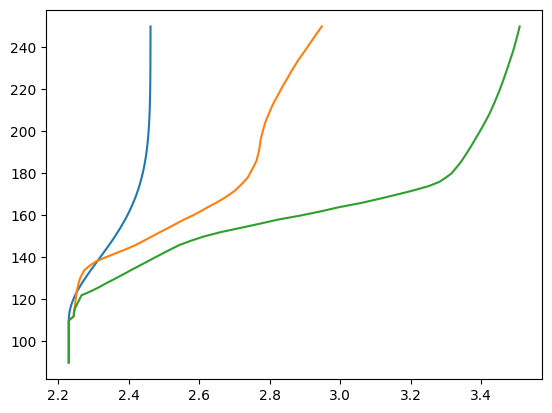

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe886e7d970>

In [6]:
fig, ax = subplots(1)
ax.plot(log.(Tn)/log(10.),alt/1e5)
ax.plot(log.(Ti)/log(10.),alt/1e5)
ax.plot(log.(Te)/log(10.),alt/1e5)

In [7]:
Tn[end]

289.9742876567245

In [8]:
D_ions = [s for s in ion_species if occursin('D', string(s))];
D_H_analogues = Dict(:ArDpl=>:ArHpl, :Dpl=>:Hpl, :DCOpl=>:HCOpl, :HDpl=>:H2pl, :HD2pl=>:H3pl, :H2Dpl=>:H3pl, :N2Dpl=>:N2Hpl,
                           :DCO2pl=>:HCO2pl, :DOCpl=>:HOCpl, :H2DOpl=>:H3Opl, :HDOpl=>:H2Opl, :ODpl=>:OHpl);
D_bearing_species = [s for s in setdiff(union(neutral_species, ion_species), [:O1D, :Nup2D]) if occursin('D', string(s))];
speciesstyle = Dict(vcat([s=>"--" for s in setdiff(D_bearing_species, [:HD2pl])], [:HD2pl=>":", :Nup2D=>"-."]) );

global speciescolor_forDions = Dict([ion=>speciescolor[ion] for ion in keys(D_H_analogues)])
# speciescolor_forDions[:H3Opl] = speciescolor[:H3Opl]

dimcolor = "xkcd:greyish"

"xkcd:greyish"

# Atmosphere plots

## Whole atm

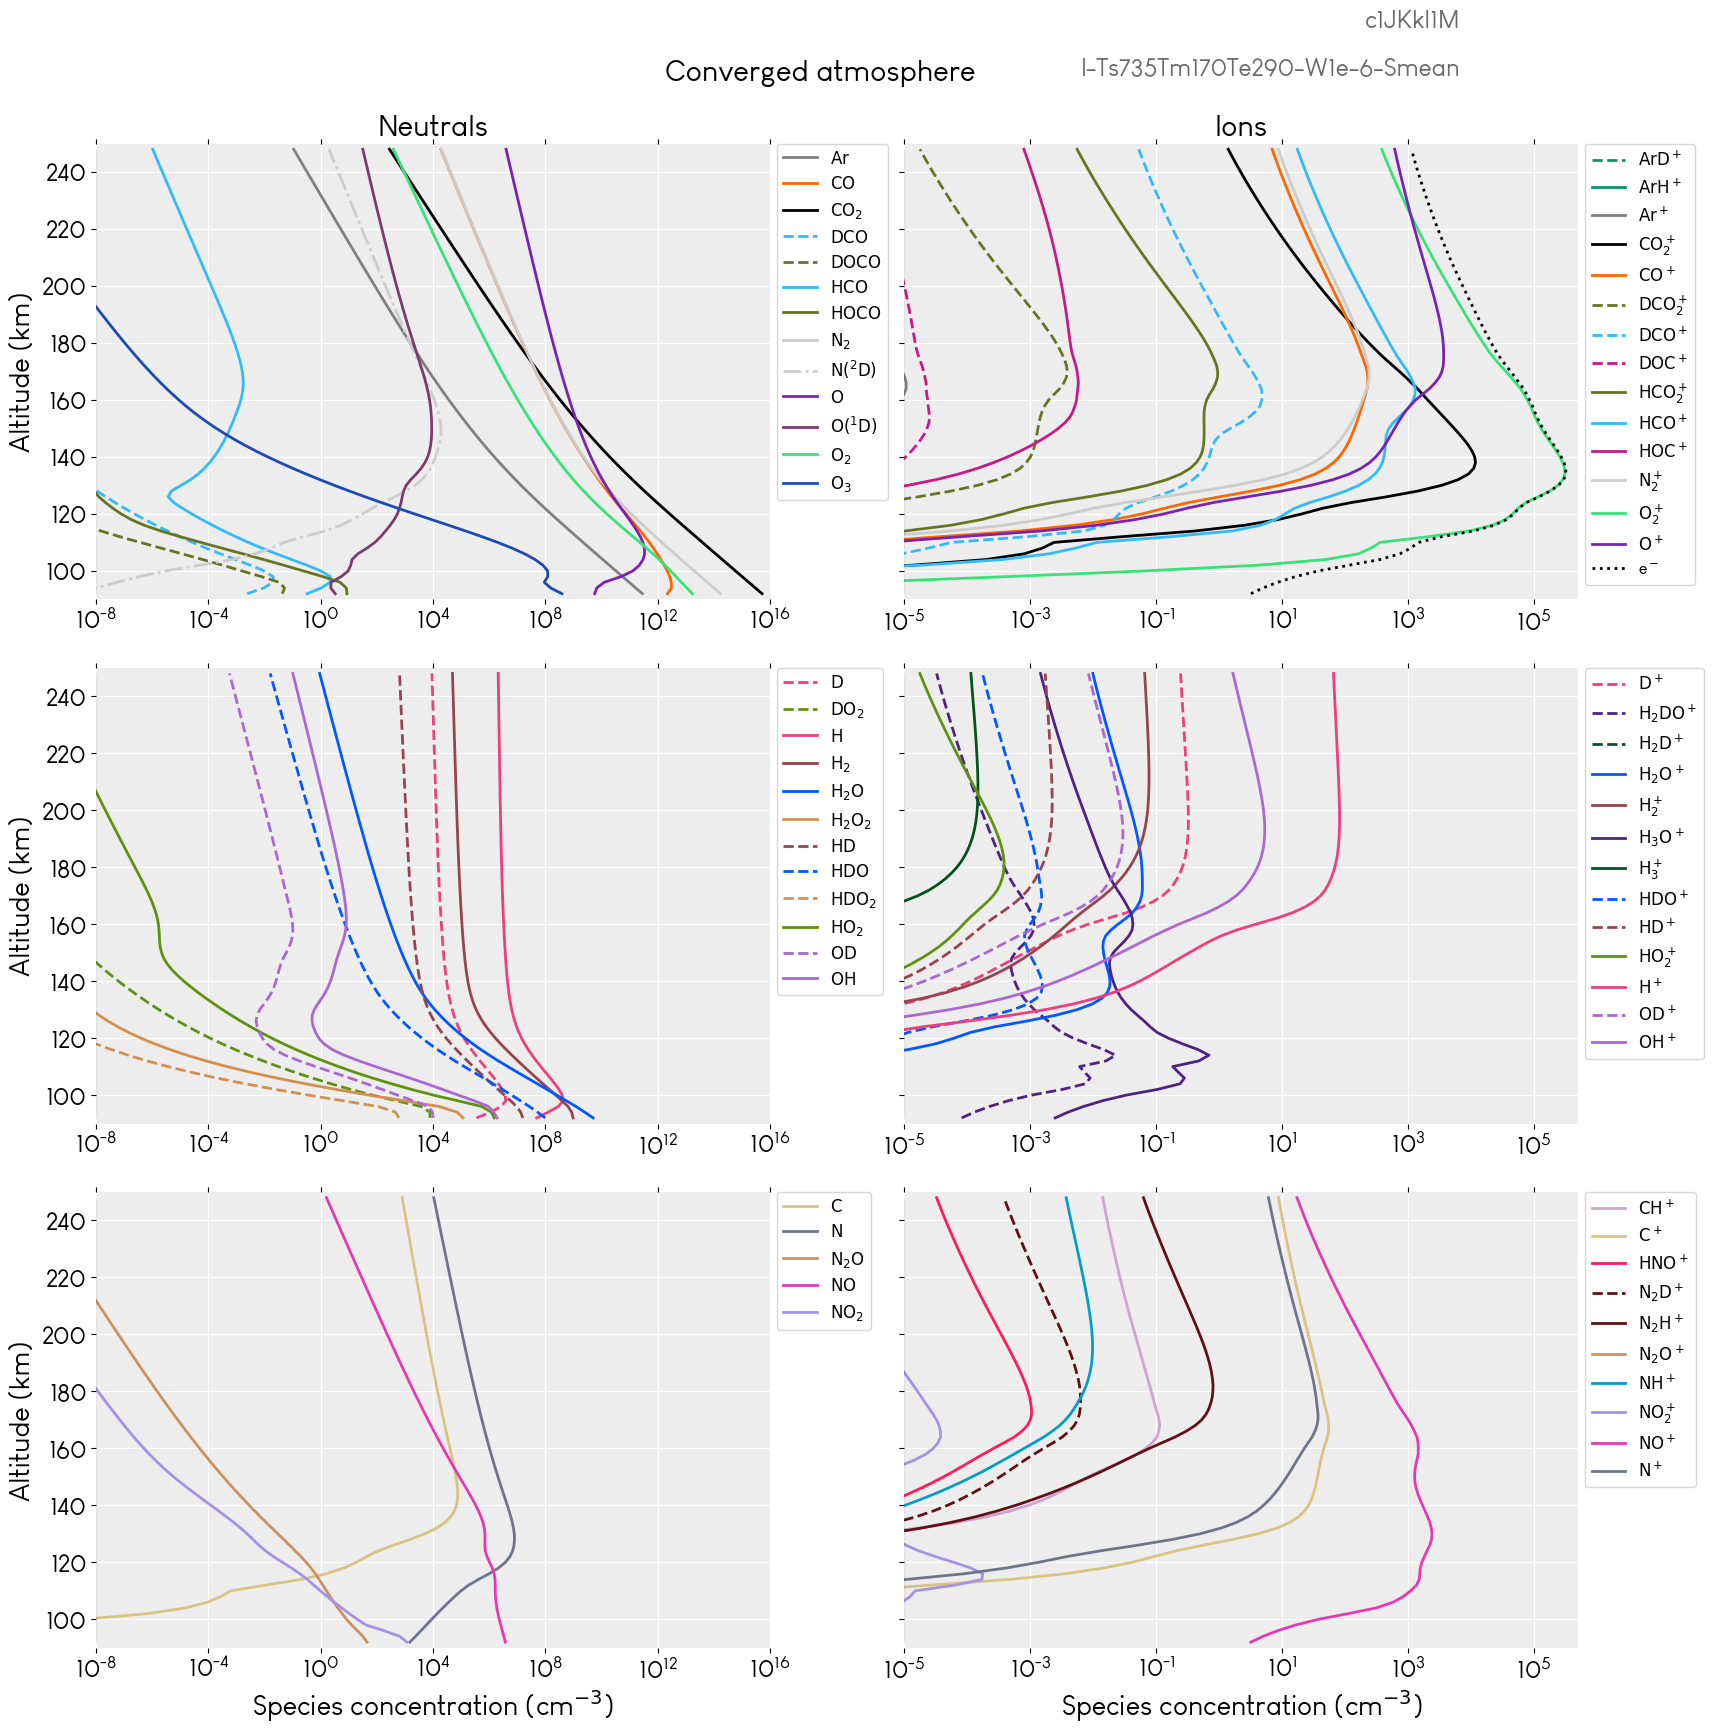

In [9]:
atm_fig_savepath = mean_folder*"final_atm_90km.png"
atm_fig = plot_atm(mean_atm, atm_fig_savepath, 1e-12, electron_density(mean_atm; e_profile_type="quasineutral", ion_species, non_bdy_layers); 
                   print_shortcodes=true, t="Converged atmosphere", 
                   xlim_1=(1e-8, 1e16), xlim_2=(1e-5, 5e5), #(3e-1,1e6),#
                   showonly=true, neutral_species, ion_species, plot_grid, speciescolor, speciesstyle, zmax,
                   hrshortcode, rshortcode,
                   ylim=[90, 250]);

In [10]:
atm_fig.savefig(atm_fig_savepath, bbox_inches="tight", dpi=300)

In [11]:
# write densities to file for bethan

eprof = electron_density(mean_atm; e_profile_type="quasineutral", ion_species, non_bdy_layers)

open(mean_folder*"output_densities_for_bethan.txt", "w") do io
    write(io, join(["alt","CO2","O","N2","CO","HCO+","e-","Te"],"\t"), "\n")
    for i in range(1,length(mean_atm[:CO2]))
        write(io, 
              string(alt[i+1]/1e5), "\t", 
              join([string(mean_atm[sp][i]) for sp in [:CO2,:O,:N2,:CO,:HCOpl]],"\t"), "\t",
              string(eprof[i]), "\t",
              string(Te[i+1]),
              "\n")
    end
end

# Check to see if Brinton+1980 equilibrium calculation gives correct H density

In [12]:
# endothermic charge exchange of Hpl + O -> Opl + H
# this is the expression used in the Brinton paper, not the one used in the model
O_level_energies = [0.00, 0.02, 0.028]
kTi = (1.0/11600.0)*Ti
k1_brinton = 8.0*exp.(-0.02/kTi)./(sum([5,3,1].*exp.(-O_level_energies/kTi), dims=1))

# (rate coefficient of Hpl +CO2 -> HCOpl + O)/(rate coefficient of Opl + H -> Hpl + O) 
# we use the rates adopted in the model, not the rates from the Brinton paper
k2_brinton = 3.8e-9/6.4e-10;

In [13]:
k1_brinton

1×81 Matrix{Float64}:
 0.888033  0.888033  0.888033  …  0.88467  0.88459  0.884508  0.88442

In [14]:
model_k1 = 3.75e-10/6.4e-10 # ratio of adopted rate coefficients (Hpl + O -> H + Opl)/(Opl + H -> O + Hpl)

0.5859375

In [15]:
foxsung_Z = 1.0 .+ 0.6.*exp.(-228 ./Tn) .+ 0.2.*exp.(-326 ./Tn)
foxsung_k1 = 8/9 .* 1.0./foxsung_Z .*(exp.(-231.2 ./Ti) .+ 0.6.*exp.(-228 ./Tn) .+ 0.2.*exp.(-326 ./Tn));

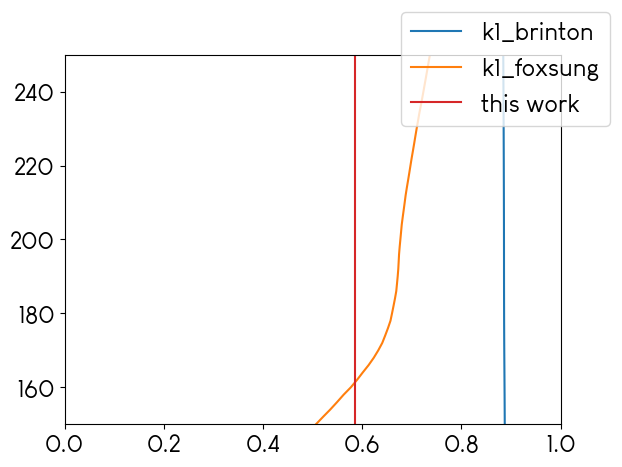

PyObject <matplotlib.legend.Legend object at 0x7fe88277ffd0>

In [16]:
fig, ax = subplots(1,1)
ax.plot(transpose(k1_brinton), alt/1e5, label="k1_brinton")
ax.plot(foxsung_k1, alt/1e5, label="k1_foxsung")
ax.axvline(model_k1, color="tab:red", label="this work")
ax.set_ylim(150,250)
ax.set_xlim(0, 1)
fig.legend()

The above indicates that the present model does not correctly simulate the reverse reaction of Hpl + O charge exchange; the adopted rate for this reaction is too small over most of the altitude where H+ is produced. This may also help to explain the lower O+ numbers in the present model vs past models and the atmosphere

In [17]:
nH_brinton = mean_atm[:Hpl]./mean_atm[:Opl].*(k1_brinton[2:end-1].*mean_atm[:O].*(Ti[2:end-1]./Tn[2:end-1]).^0.5 .+ k2_brinton.*mean_atm[:CO2]);
nH_foxsung = mean_atm[:Hpl]./mean_atm[:Opl].*(foxsung_k1[2:end-1].*mean_atm[:O].*(Ti[2:end-1]./Tn[2:end-1]).^0.5 .+ k2_brinton.*mean_atm[:CO2]);
nH_thismodelk1 = mean_atm[:Hpl]./mean_atm[:Opl].*(model_k1.*mean_atm[:O].*(Ti[2:end-1]./Tn[2:end-1]).^0.5 .+ k2_brinton.*mean_atm[:CO2]);

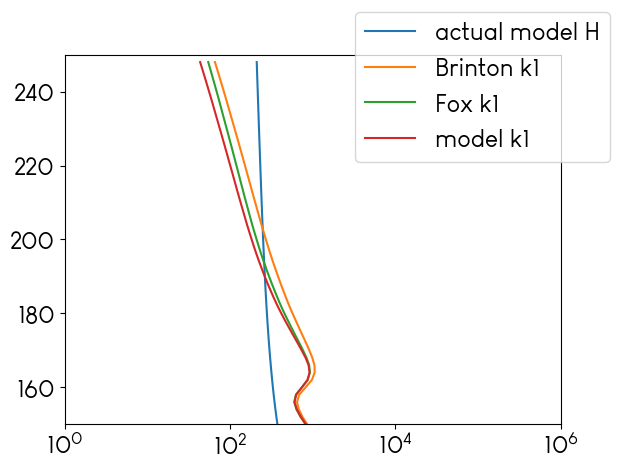

PyObject <matplotlib.legend.Legend object at 0x7fe8824d2760>

In [18]:
fig, ax = subplots(1,1)
ax.plot(mean_atm[:H]/1e4,alt[2:end-1]/1e5, label="actual model H")
ax.plot(nH_brinton/1e4,alt[2:end-1]/1e5, label="Brinton k1")
ax.plot(nH_foxsung/1e4,alt[2:end-1]/1e5, label="Fox k1")
ax.plot(nH_thismodelk1/1e4,alt[2:end-1]/1e5, label="model k1")

#ax.plot(mean_atm[:Hpl],alt[2:end-1]/1e5, label="H+")
#ax.plot(mean_atm[:O]/1e4,alt[2:end-1]/1e5, label="O")
#ax.plot(mean_atm[:Opl],alt[2:end-1]/1e5, label="O+")
ax.set_xscale("log")
ax.set_ylim(150,250)
ax.set_xlim(1,1e6)
fig.legend()

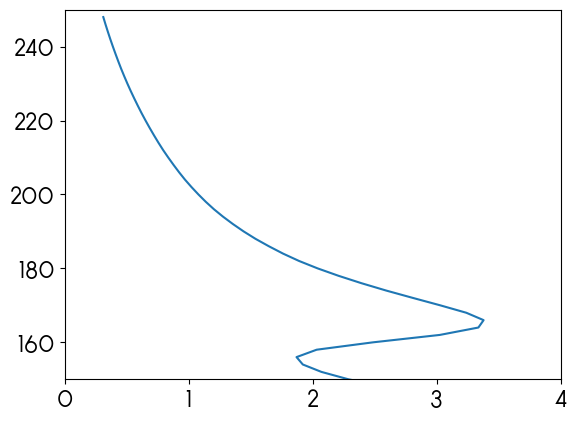

(150.0, 250.0)

In [19]:
fig, ax = subplots(1,1)
ax.plot(nH_brinton./mean_atm[:H],alt[2:end-1]/1e5)
ax.set_xlim(0,4)
#ax.set_xscale("log")
#ax.set_xlim(0.1,10)
ax.set_ylim(150,250)

These results and the model chemeq plots indicate that vertical transport can significantly perturb H densities, limiting the utility of the Brinton photochemical equilibrium argument

# Get D/H ratios in atmosphere

In [20]:
mean_atm[:D]./mean_atm[:H]

79-element Vector{Float64}:
 0.007171182953012499
 0.0088103607486165
 0.009216919267380174
 0.009095471443041936
 0.009295625476497734
 0.009550769781869929
 0.009773854733258598
 0.009932854853959784
 0.01000912887775669
 0.009993505423502982
 0.009890103250379322
 0.00971223376398893
 0.009477014499166237
 ⋮
 0.004718110926222248
 0.004685587639106671
 0.004653326443917616
 0.004621323233602083
 0.004589574195676403
 0.004558075773327088
 0.004526824631480827
 0.004495817627278018
 0.004465051784562656
 0.004434524271884868
 0.0044042323835821766
 0.004374173523596685

In [21]:
(mean_atm[:D]./mean_atm[:H])/(1/6420)

79-element Vector{Float64}:
 46.03899455834024
 56.56251600611793
 59.17262169658071
 58.392926664329224
 59.67791555911545
 61.31594199960494
 62.7481473875202
 63.768928162421815
 64.25860739519794
 64.15830481888915
 63.494462867435246
 62.35254076480893
 60.84243308464724
  ⋮
 30.290272146346833
 30.081472643064828
 29.874355769951094
 29.668895159725373
 29.465066336242504
 29.262846464759903
 29.06221413410691
 28.863149167124874
 28.665632456892254
 28.469645825500855
 28.275171902597574
 28.082194021490718

In [22]:
(mean_atm[:HDO]./mean_atm[:H2O])

79-element Vector{Float64}:
 0.01982328285705153
 0.02073663393903093
 0.021835111608986168
 0.023185565228829235
 0.024515289711178688
 0.025674516740228654
 0.02660336459274799
 0.027296554825506497
 0.027787218585806066
 0.028122932572833034
 0.02834570494025556
 0.0284853509423364
 0.02855967926125558
 ⋮
 0.018663846918042626
 0.01853585989123673
 0.018408831599247957
 0.018282751482788698
 0.01815760973117865
 0.018033397169443004
 0.017910105159928382
 0.0177877255170185
 0.017666250433698898
 0.017545672418873448
 0.017425984244157477
 0.017307178899008836

In [23]:
(mean_atm[:HDO]./mean_atm[:H2O])/(1/6420)

79-element Vector{Float64}:
 127.26547594227083
 133.12918988857857
 140.1814165296912
 148.8513287690837
 157.38815994576717
 164.83039747226795
 170.7936006854421
 175.2438819797517
 178.39394332087494
 180.54922711758806
 181.9794257164407
 182.87595304979968
 183.35314085726083
   ⋮
 119.82189721383365
 119.00022050173979
 118.18469886717187
 117.37526451950343
 116.57185447416693
 115.77440982782409
 114.98287512674021
 114.19719781925878
 113.41732778434692
 112.64321692916754
 111.874818847491
 111.11208853163672

These results indicate that HDO/H2O is expected to be about 5x as enriched in D as the atomic species, potentially resolving the discrepancy between remote sensing and in-situ measurements of water D/H and the Bertaux&Clarke1989 remote sensing measurement of very little thermospheric D.

# Get D+/H2+ ratios

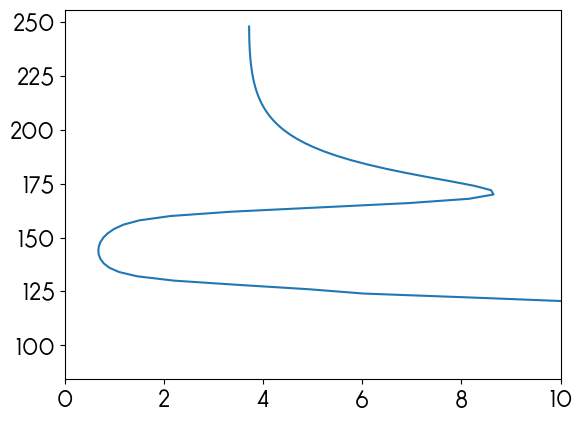

(0.0, 10.0)

In [24]:
fig, ax = subplots(1,1)
ax.plot((mean_atm[:Dpl]./mean_atm[:H2pl]),alt[2:end-1]/1e5)
ax.set_xlim(0,10)
#ax.set_xscale("log")

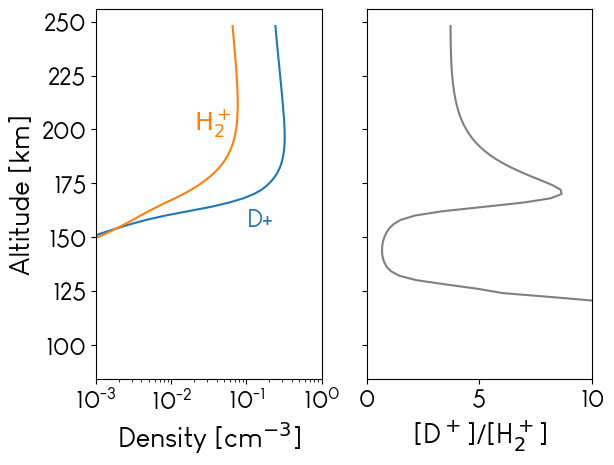

PyObject Text(0.5, 47.89999999999999, '[D$^+$]/[H$_2^+$]')

In [25]:
fig, (ax_dens, ax_ratio) = subplots(1,2,sharey=true)
ax_dens.plot(mean_atm[:Dpl],alt[2:end-1]/1e5)
ax_dens.plot(mean_atm[:H2pl],alt[2:end-1]/1e5)
#ax.set_xlim(0,10)
ax_dens.set_xscale("log")
ax_dens.set_xlim(1e-3,1)
ax_dens.set_ylabel("Altitude [km]")
ax_dens.set_xlabel("Density [cm"*L"^{-3}"*"]")
ax_dens.text(0.1,155,"D+", color="tab:blue")
ax_dens.text(0.02,200,L"\mathrm{H}_2^+", color="tab:orange")

ax_ratio.plot(mean_atm[:Dpl]./mean_atm[:H2pl],alt[2:end-1]/1e5, color="gray")
ax_ratio.set_xlim(0,10)
ax_ratio.set_xlabel("[D"*L"^+"*"]/"*"[H"*L"_2^+"*"]")

## H and D ion detail

In [26]:
ions_to_plot = [:HDpl, :H2Dpl, :H2DOpl, :HDOpl, :Dpl, :DCO2pl, :DCOpl, :ArDpl, :N2Dpl, :ODpl,
                :H2pl, :H3pl,  :H3Opl,  :H2Opl, :Hpl, :HCO2pl, :HCOpl,  :ArHpl, :N2Hpl, :OHpl]#, :NOpl, :HOCpl,
panel_groups = Dict(1=>[:H2Dpl, :H3pl,  :HDOpl, :H2Opl, :Dpl, :Hpl, :H2DOpl, :H3Opl, :ODpl, :OHpl,  ], 
                    2=>[:ArDpl, :ArHpl, :N2Dpl, :N2Hpl,  :DCOpl, :HCOpl,  :DCO2pl, :HCO2pl, :HOCpl, :H2pl, :HDpl, :NOpl]) # :DOCpl,
axes_by_sp = Dict()
for k in keys(panel_groups)
    for sp in panel_groups[k]
        axes_by_sp[sp] = k
    end
end

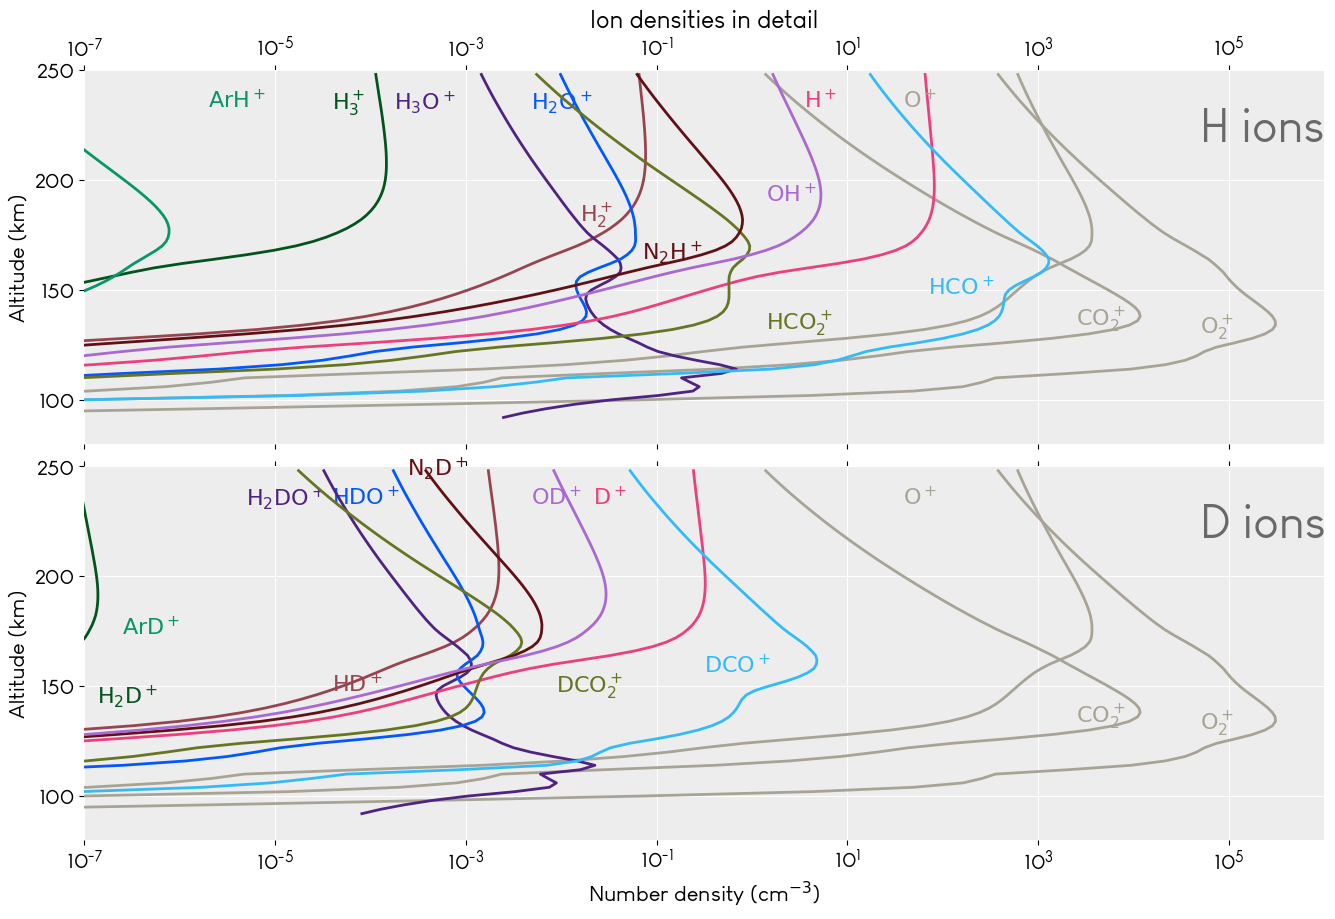

In [27]:
plot_ion_ranges_wide_2panel(ions_to_plot, mean_folder, all_result_plot_folder; extra_fn="_densities", 
                 xL = [1e-7; 1e6],    
                 posdict = Dict(:ArHpl => [0.1, 0.95], :Hpl => [0.58, 0.95], :HCOpl=>[0.68, 0.45], :HCO2pl => [0.55, 0.36],
                                 :H2Opl => [0.36, 0.95], :H3Opl => [0.25, 0.95], :H2pl => [0.4, 0.65], 
                                 :H3pl => [0.2, 0.95], :N2Hpl => [0.45, 0.55], :OHpl => [0.55, 0.7],
                                 :CO2pl=>[0.8, 0.37], :O2pl=>[0.9, 0.35], :Opl=>[0.66, 0.95],  
    
                                 :ArDpl => [0.03, 0.6], :Dpl => [0.41, 0.95], :DCOpl => [0.5, 0.5], :DCO2pl => [0.38, 0.45],
                                 :HDOpl => [0.2, 0.95], :H2DOpl => [0.13, 0.95], :HDpl => [0.2, 0.45], 
                                 :H2Dpl => [0.01, 0.42], :N2Dpl => [0.26, 1.03], :ODpl => [0.36, 0.95], 
                                 ))

# Escape

In [28]:
# LOad the reaction network for hot stuff cause we need that
reaction_network, hHnet, hDnet, hH2net, hHDnet = load_reaction_network("REACTION_NETWORK_VENUS.xlsx"; get_hot_rxns=true, all_species);
hHrc = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hHnet]);
hDrc = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hDnet]);
hH2rc = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hH2net]);
hHDrc = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hHDnet]);

In [29]:
esc_df = final_escape(mean_folder, "final_atmosphere.h5"; alt, all_species, dz, hHnet, hDnet, hH2net, hHDnet, hHrc, hDrc, hH2rc, hHDrc)

,EscapeType,H,D,H2,HD,Hpl,H2pl,TotalNeutralHAtomsLost
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Thermal,0.0,0.0,1.9999e-8,1.44682e-19,0.0,0.0,3.99981e-8
2,Nonthermal,2.30062e7,43463.2,2273.41,5.42507,0.0,0.0,2.30108e7
3,Total,2.30062e7,43463.2,2273.41,5.42507,0.0,0.0,2.30108e7


In [30]:
show(esc_df, allcols=true)


3×10 DataFrame
 Row │ EscapeType  H          D        H2            HD           Hpl      H2pl     TotalNeutralHAtomsLost  TotalNeutralDAtomsLost  TotalNeutralAtomsLost 
     │ String      Float64    Float64  Float64       Float64      Float64  Float64  Float64                 Float64                 Float64               
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Thermal     0.0            0.0     1.9999e-8  1.44682e-19      0.0      0.0              3.99981e-8              3.99981e-8             1.19994e-7
   2 │ Nonthermal  2.30062e7  43463.2  2273.41       5.42507          0.0      0.0              2.30108e7               2.30542e7              6.91192e7
   3 │ Total       2.30062e7  43463.2  2273.41       5.42507          0.0      0.0              2.30108e7               2.30542e7              6.91192e7

## Fractionation

In [31]:
hdo_bottom = mean_atm[:HDO][1]
h2o_bottom = mean_atm[:H2O][1]

5.062400008182522e9

In [32]:
fractionation_factor(esc_df, h2o_bottom, hdo_bottom)

0.19058977068613403

In [33]:
fractionation_factor(esc_df, h2o_bottom, hdo_bottom; ftype="thermal")

3.649476493872712e-10

In [34]:
fractionation_factor(esc_df, h2o_bottom, hdo_bottom; ftype="nonthermal")

0.19058977068613436

## Top mechanisms of escape

In [35]:
function plot_top5_lineandbar(total_dfs_H, total_dfs_D, by_alt_dfs_H, by_alt_dfs_D; savepath=nothing, nrow=1, ncol=2,
                              lowerlim=1e-5, upperlim=1, coltitle=["Mean atm"], 
                              h=0.1, w=0.1, title_y=[1.2, 1.05, 1.05]) 
    #=
    Input:
        sp: H or D usually
        total_dfs: Array of dataframes of total fluxes by reaction
        by_alt_dfs: Array of dataframes containing production profiles by altitude and by reaction
    Output: 
        Plot of the production profiles of the 5 reactions that produce the most flux
        of hot H and D.
    =#
    
    # Generate colors
    colordf = DataFrame(XLSX.readtable("IMPORTANT_RXN_COLORS.xlsx", "Sheet1"));

    # make labels not suck
    format_scin(n) = @sprintf "%.2E" n
    
    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 18
    rcParams["axes.labelsize"]= 20
    rcParams["xtick.labelsize"] = 18
    rcParams["ytick.labelsize"] = 18
    
    
    # Set up the figure dimensions
    npanel = nrow > ncol ? nrow : ncol 
    println("npanel: $npanel")
    fig, ax = subplots(nrow, ncol, figsize=(7.5*ncol, 5*nrow))
    subplots_adjust(wspace=w, hspace=h)
    
    println(size(ax))
    
    # SET UP THE REACTION RATE SET -----------------------------------------------------
  
    # all panels
    plot_bg(ax[1])
    ax[1].set_ylabel("Altitude (km)")
    # ax[1].text(1.07, title_y[i], coltitle, transform=ax[i, 1].transAxes, size=20)
    ax[1].set_xlim(lowerlim[1], upperlim[1]) # H plot limits
    ax[1].tick_params(which="both", labeltop=false, labelbottom=true, top=true)
    ax[1].set_ylim(100, 250)
    ax[1].set_xscale("log")
    ax[1].set_title("Production mechanisms", size=16)
    ax[1].set_xlabel(L"Volume production rate (cm$^{-3}$ s$^{-1}$)")
    
    # color set
    # H is first column, D second column
    H_colororder = []
    H_colororder_dark = []
    D_colororder = []
    D_colororder_dark = []
    # Plot the H reactions
    for row in eachrow(total_dfs_H)[1:5]
        thiscol = colordf[in([row.Rxn]).(colordf."H reaction"), :]."Color"[1]
        push!(H_colororder, thiscol)
        push!(H_colororder_dark, colordf[in([row.Rxn]).(colordf."H reaction"), :]."Darker"[1])
        ax[1].plot(by_alt_dfs_H[!, row.Rxn], plot_grid, label=row.Rxn, linewidth=2, color=thiscol)
    end
    # And the D reactions
    for row in eachrow(total_dfs_D)[1:5]
        thiscol = colordf[in([row.Rxn]).(colordf."D reaction"), :]."Color"[1]
        thiscol_dark = colordf[in([row.Rxn]).(colordf."D reaction"), :]."Darker"[1]
        push!(D_colororder, thiscol)
        push!(D_colororder_dark, thiscol_dark)

        ax[1].plot(by_alt_dfs_D[!, row.Rxn], plot_grid, label=row.Rxn, linewidth=2, linestyle=(0, (10,4)),
                 mfc="black", mec="black", color=thiscol)
    end
    
    println(H_colororder)
    
    
    rcParams["hatch.linewidth"] = 1
    rcParams["hatch.color"] = "magenta"
    # NOW DO THE BAR CHART SET -------------------------------------------------------------------------
    # Make ticklabels
    H_ticklbls = ["$(string_to_latexstr(H_i))" for H_i in total_dfs_H[1:5, :].Rxn]
    D_ticklbls = ["$(string_to_latexstr(D_i))" for D_i in total_dfs_D[1:5, :].Rxn]

    # basics
    plot_bg(ax[2])
    ax[2].tick_params(top=true, left=false, labelleft=false)
    ax[2].set_xlim(1e2, 1e8)
    ax[2].set_xscale("log")
    ax[2].invert_yaxis()

    # Bars 
    barw=0.5
    ax[2].barh(collect(1:5), total_dfs_H[1:5, :].Value, height=-barw, color=H_colororder, align="edge", zorder=10, edgecolor=H_colororder_dark)
    ax[2].barh(collect(1:5), total_dfs_D[1:5, :].Value, height=barw, color=D_colororder,  fill=false, 
                  align="edge", zorder=10, hatch="///", edgecolor=D_colororder)

    # Values
    for (i, f) in enumerate(total_dfs_H[1:5, :].Value)
        ax[2].text(f*0.9, i-barw/2, "$(format_scin(f))", ha="right", va="center", color="white", size=12, zorder=15)
    end
    for (i, f) in enumerate(total_dfs_D[1:5, :].Value)
        ax[2].text(f*1.2, i+barw/2, "$(format_scin(f))", ha="left", va="center", color="black", size=12, zorder=15)
    end

    # Tick labels, but manually, to make coloring better
    x = 7e1
    for y in 1:5
        ax[2].text(x, y - 0.15, H_ticklbls[y], color=H_colororder[y], fontsize=14, ha="right")
        ax[2].text(x, y + 0.35, D_ticklbls[y], color=D_colororder[y], fontsize=14, ha="right")
    end
    
    ax[2].set_title("Reaction contributions to escape", size=16)
    ax[2].set_xlabel(L"H & D Escape flux (cm$^{-2}$s$^{-1}$)")
    
    # Label H and D
    ax[1].text(1e-7, 160, "D-bearing")
    ax[1].text(1e-2, 120, "H-bearing")
    
    if savepath!=nothing
        savefig(savepath*"hot_mechanisms_line_bar.png", bbox_inches="tight", dpi=300)
    else
        show()
    end
end

plot_top5_lineandbar (generic function with 1 method)

In [36]:
# Get the Jratelist because we need it for nonthermal bcs
Jratelist = format_Jrates(mean_folder*"active_rxns.xlsx", all_species, "Jratelist"; hot_atoms=true, ions_on=true)[1];
Jratedict = Dict([j=>mean_atm[j] for j in Jratelist])

Mtot = sum([mean_atm[sp] for sp in all_species]);
# H
H_prod_by_alt = escaping_hot_atom_production(:H, hHnet, hHrc, mean_atm, Mtot; all_species, alt, collision_xsect, dz, ion_species, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax);
H_prod_by_alt_df = escaping_hot_atom_production(:H, hHnet, hHrc, mean_atm, Mtot; returntype="df", all_species, alt, collision_xsect, dz, ion_species, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax);
total_hot_H = nonthermal_escape_flux(hHnet, H_prod_by_alt; dz); # This is already sorted within the function here.

D_prod_by_alt = escaping_hot_atom_production(:D, hDnet, hDrc, mean_atm, Mtot; all_species, alt, collision_xsect, dz, ion_species, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)
D_prod_by_alt_df = escaping_hot_atom_production(:D, hDnet, hDrc, mean_atm, Mtot; returntype="df", all_species, alt, collision_xsect, dz, ion_species, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)
total_hot_D = nonthermal_escape_flux(hDnet, D_prod_by_alt; dz);

npanel: 2
(2,)
Any["#e23209", "#332288", "#CC6677", "#44AA99", "#bf11af"]


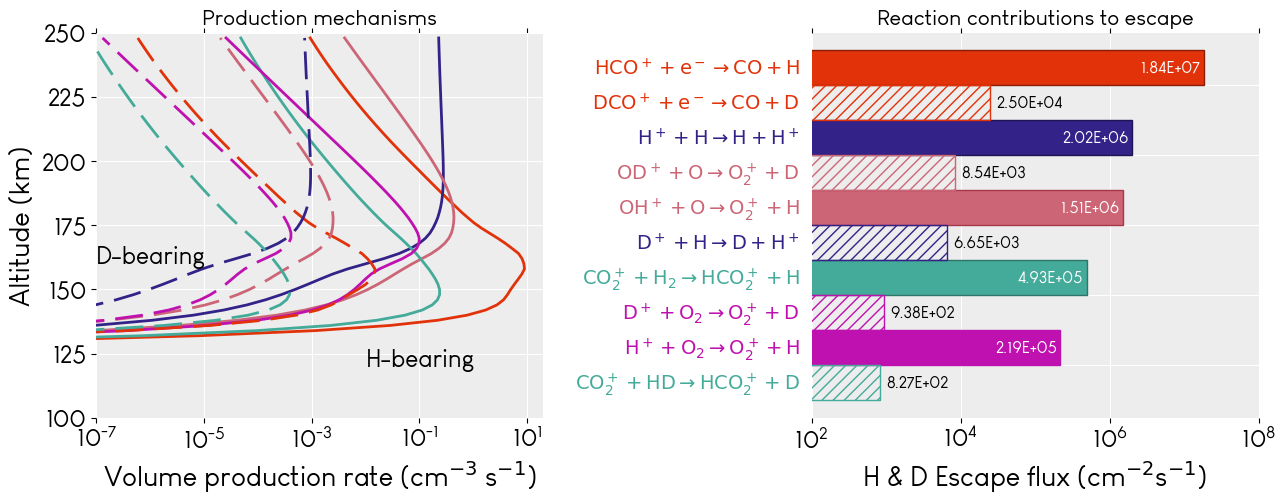

In [37]:
plot_top5_lineandbar(total_hot_H, total_hot_D, H_prod_by_alt_df, D_prod_by_alt_df; savepath=mean_folder,
                     nrow=1, ncol=2,
                     lowerlim=[1e-7,1e-7,1e-7], upperlim=[20,20,20], w=0.6, h=0.25,
                     coltitle=["Mean atmo"])

# Examine production rates of various species to compare with other models and data

Top 5 production reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                        Value
     │ String                     Float64
─────┼───────────────────────────────────────
   1 │ CO2 --> CO2pl              2.45532e10
   2 │ COpl + CO2 --> CO2pl + CO  4.38606e9
   3 │ N2pl + CO2 --> CO2pl + N2  1.31086e9
   4 │ Npl + CO2 --> CO2pl + N    2.22258e8
   5 │ Cpl + CO2 --> CO2pl + C    1.7019e8


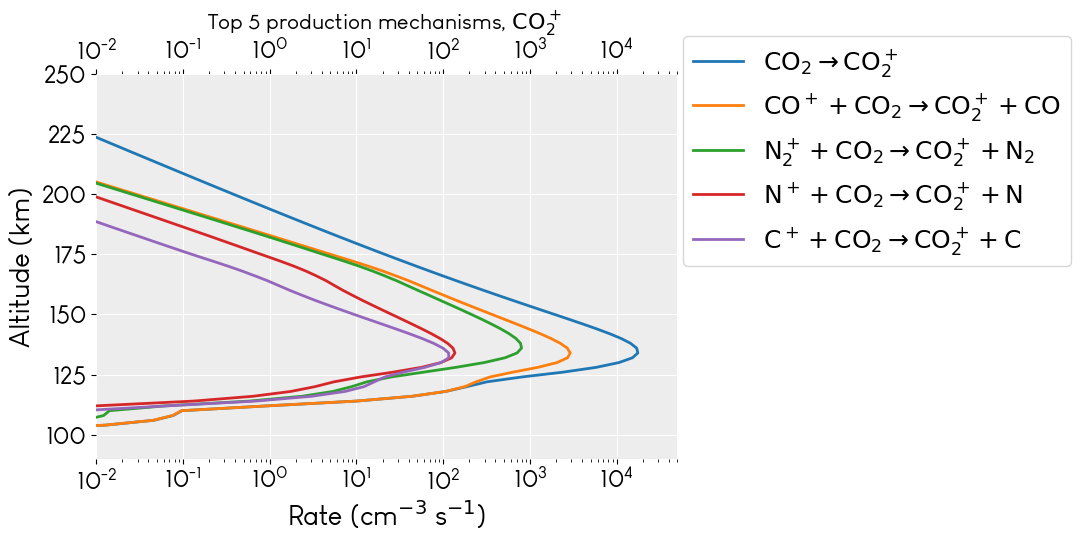

In [38]:
top_mechanisms(5, :CO2pl, mean_atm, "product"; y0=90, lowerlim=1e-2, upperlim=5e4, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 3 production reactions sorted by highest column value: 3×2 DataFrame
 Row │ Rxn                      Value
     │ String                   Float64
─────┼─────────────────────────────────────
   1 │ CO2pl + O --> Opl + CO2  1.04544e10
   2 │ CO2 --> Opl + CO         2.7576e9
   3 │ O --> Opl                2.48729e9


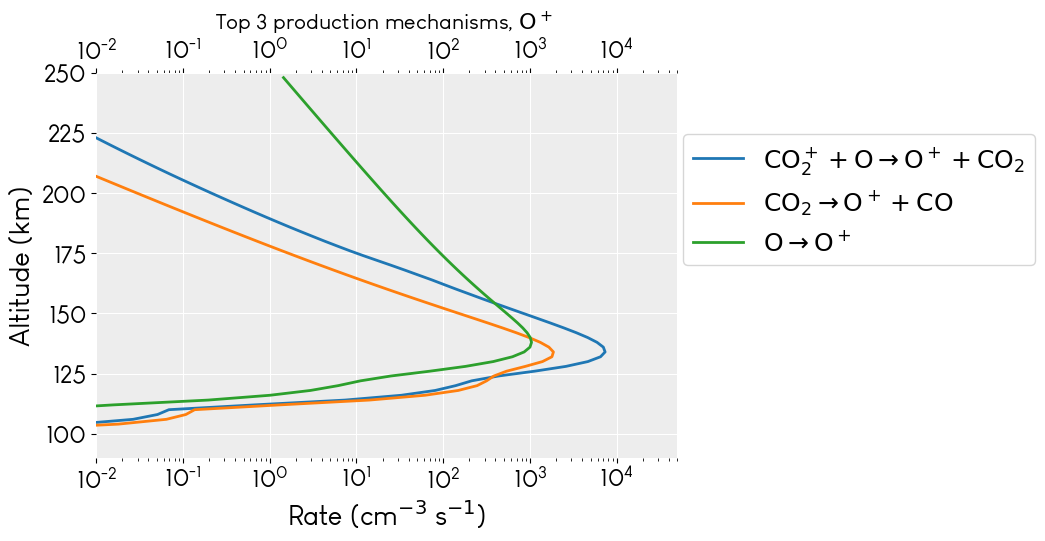

In [39]:
top_mechanisms(3, :Opl, mean_atm, "product"; y0=90, lowerlim=1e-2, upperlim=5e4, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 3 loss reactions sorted by highest column value: 3×2 DataFrame
 Row │ Rxn                      Value
     │ String                   Float64
─────┼─────────────────────────────────────
   1 │ Opl + CO2 --> O2pl + CO  1.59438e10
   2 │ Opl + H --> Hpl + O      3.43786e7
   3 │ Opl + N2 --> NOpl + N    4.11659e6


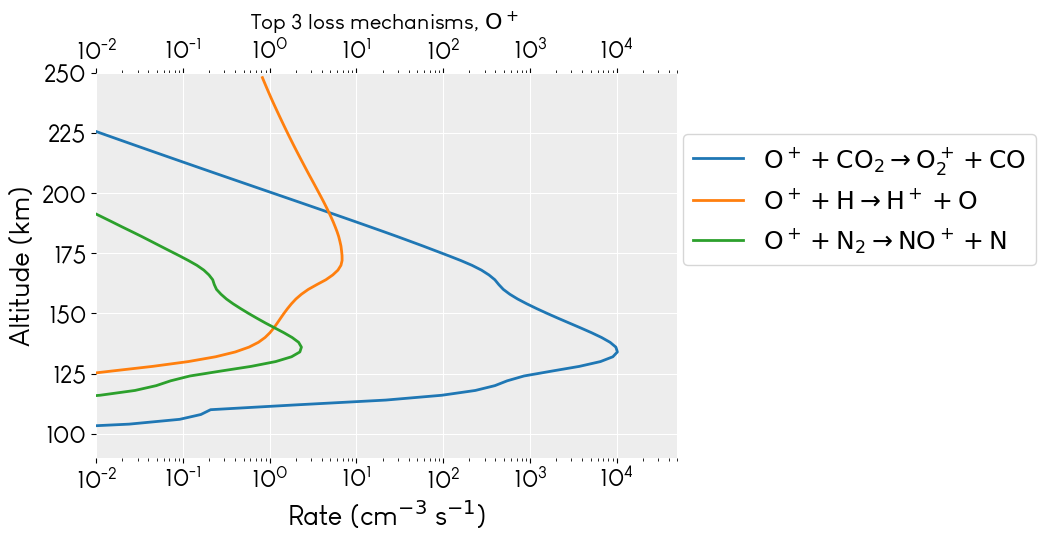

In [40]:
top_mechanisms(3, :Opl, mean_atm, "reactant"; y0=90, lowerlim=1e-2, upperlim=5e4, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 5 production reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                      Value
     │ String                   Float64
─────┼────────────────────────────────────
   1 │ Opl + H --> Hpl + O      3.43786e7
   2 │ CO2pl + H --> Hpl + CO2  5.82278e6
   3 │ H --> Hpl                3.64563e6
   4 │ Hpl + H --> H + Hpl      2.41149e6
   5 │ COpl + H --> Hpl + CO    1.32782e6


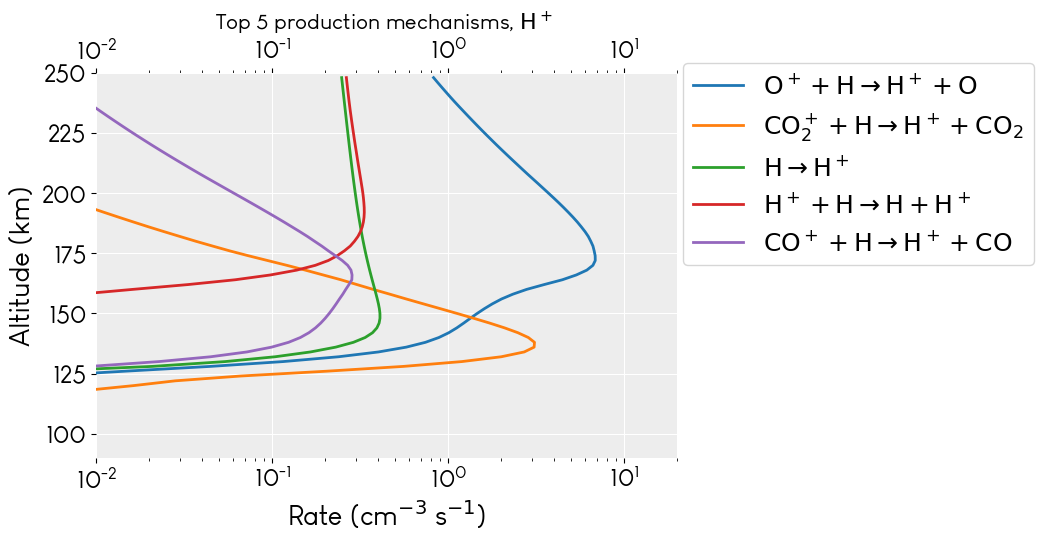

In [41]:
top_mechanisms(5, :Hpl, mean_atm, "product"; y0=90, lowerlim=1e-2, upperlim=2e1, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 5 loss reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                      Value
     │ String                   Float64
─────┼───────────────────────────────────────
   1 │ Hpl + CO2 --> HCOpl + O     2.62696e7
   2 │ Hpl + O --> Opl + H         1.86028e7
   3 │ Hpl + H --> H + Hpl         2.41149e6
   4 │ Hpl + O2 --> O2pl + H       3.20469e5
   5 │ Hpl + NO --> NOpl + H    1221.16


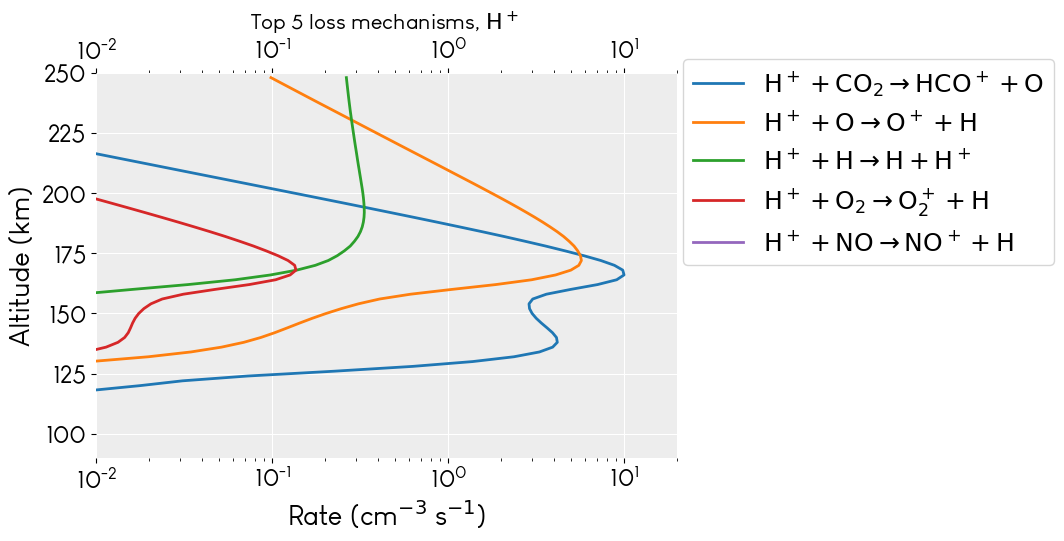

In [42]:
top_mechanisms(5, :Hpl, mean_atm, "reactant"; y0=90, lowerlim=1e-2, upperlim=2e1, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 5 production reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                          Value
     │ String                       Float64
─────┼────────────────────────────────────────
   1 │ CO2pl + H --> HCOpl + O      4.73825e7
   2 │ Hpl + CO2 --> HCOpl + O      2.62696e7
   3 │ HCO2pl + O --> HCOpl + O2    2.94487e6
   4 │ HCO2pl + CO --> HCOpl + CO2  1.88968e6
   5 │ OHpl + CO --> HCOpl + O      2.07292e5


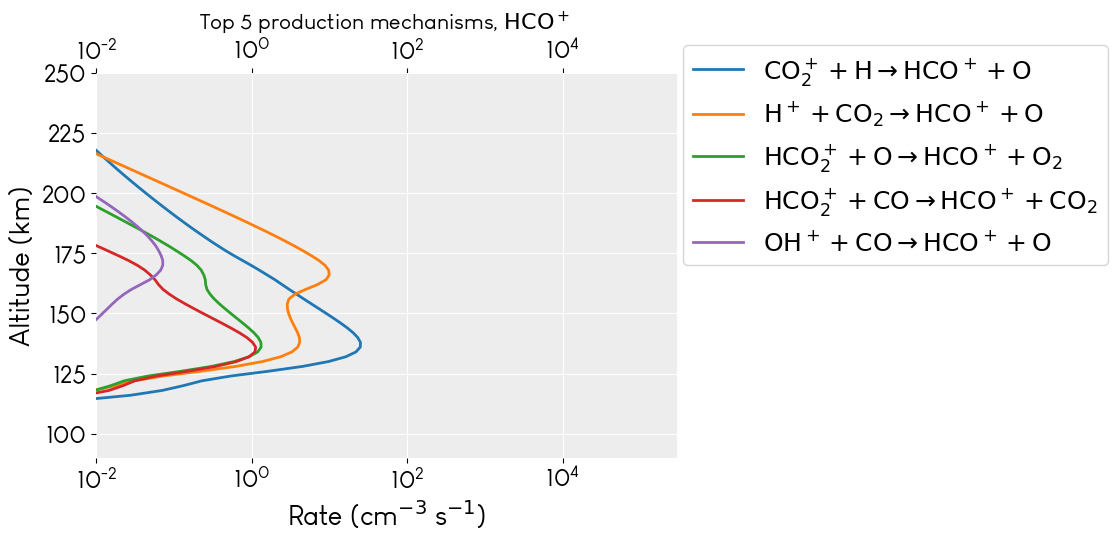

In [43]:
top_mechanisms(5, :HCOpl, mean_atm, "product"; y0=90, lowerlim=1e-2, upperlim=3e5, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 5 loss reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                         Value
     │ String                      Float64
─────┼───────────────────────────────────────────
   1 │ HCOpl + E --> CO + H            7.4578e7
   2 │ HCOpl + E --> OH + C            4.3254e5
   3 │ HCOpl + C --> CHpl + CO         1.59923e5
   4 │ HCOpl + H2O --> H3Opl + CO  15087.2
   5 │ HCOpl + D --> DCOpl + H      3876.71


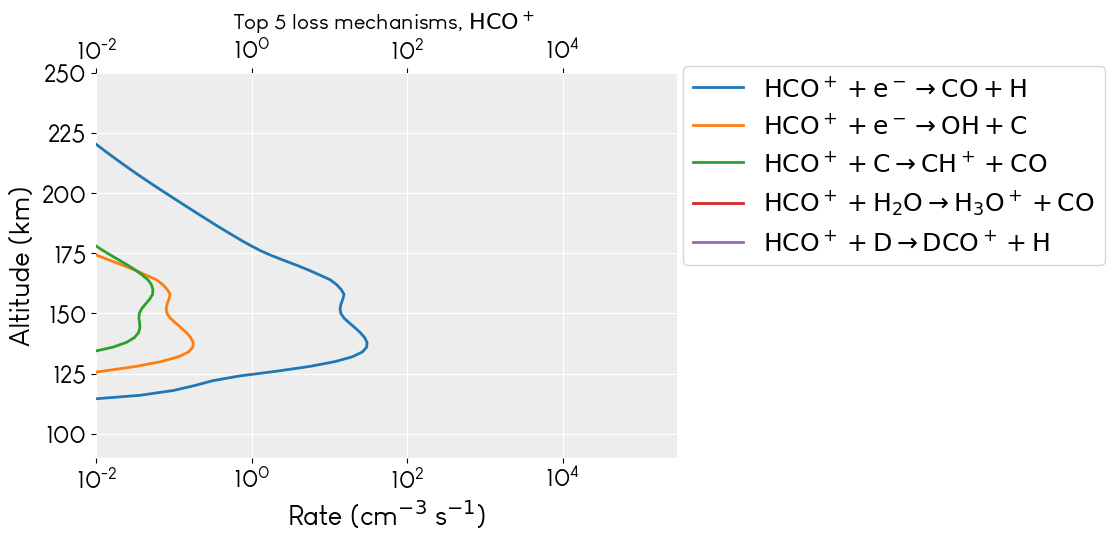

In [44]:
top_mechanisms(5, :HCOpl, mean_atm, "reactant"; y0=90, lowerlim=1e-2, upperlim=3e5, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 5 production reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                          Value
     │ String                       Float64
─────┼─────────────────────────────────────────────
   1 │ CO2pl + H2 --> HCO2pl + H         4.21286e6
   2 │ OHpl + CO2 --> HCO2pl + O         5.0154e5
   3 │ N2Hpl + CO2 --> HCO2pl + N2  106869.0
   4 │ CO2pl + H2O --> HCO2pl + OH   42747.6
   5 │ H2pl + CO2 --> HCO2pl + H     20515.3


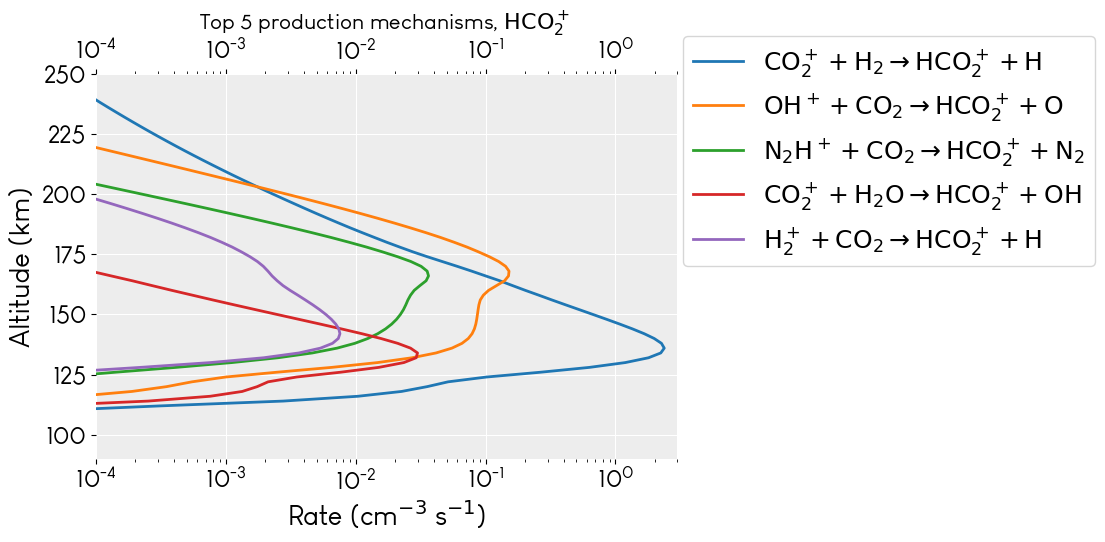

In [45]:
top_mechanisms(5, :HCO2pl, mean_atm, "product"; y0=90, lowerlim=1e-4, upperlim=3e0, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

Top 5 loss reactions sorted by highest column value: 5×2 DataFrame
 Row │ Rxn                          Value
     │ String                       Float64
─────┼────────────────────────────────────────────
   1 │ HCO2pl + O --> HCOpl + O2        2.94487e6
   2 │ HCO2pl + CO --> HCOpl + CO2      1.88968e6
   3 │ HCO2pl + E --> CO + O + H    67840.5
   4 │ HCO2pl + E --> CO + OH       26936.7
   5 │ HCO2pl + E --> CO2 + H        4988.27


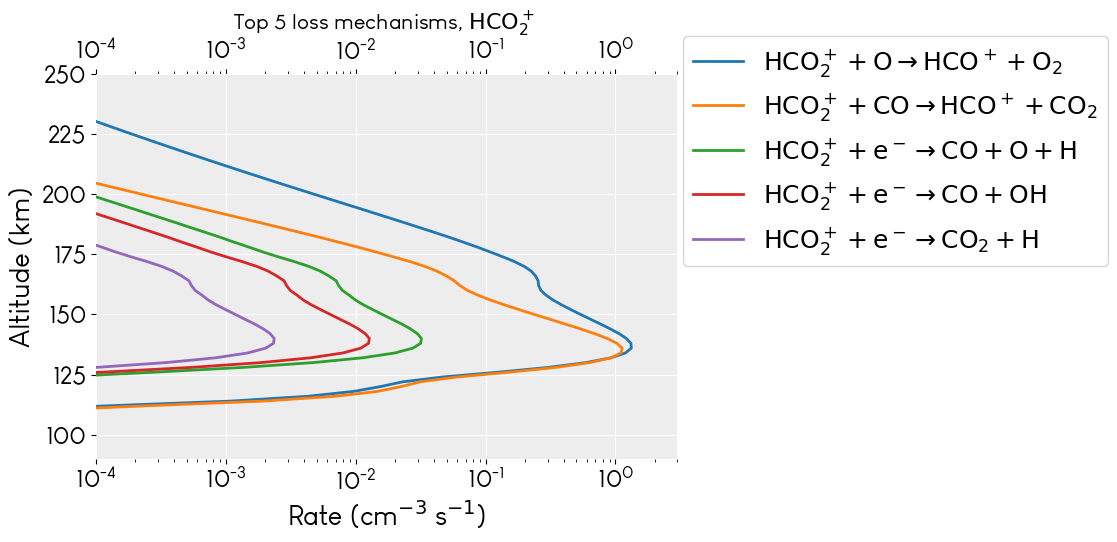

In [46]:
top_mechanisms(5, :HCO2pl, mean_atm, "reactant"; y0=90, lowerlim=1e-4, upperlim=3e0, all_species, alt, collision_xsect, dz, ion_species, reaction_network, Jratedict=Jratedict, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn, Ti=Ti, Te=Te, zmax)

## Write out new atmosphere with fewer altitudes